In [1]:
import matplotlib.pyplot as plt
import load_data as ld
import segment_tiles as st
import importlib

Calculating grey level features:  11%|█         | 56/500 [00:00<00:00, 555.83it/s]

removing subjects: ['12']
Control N3-od-1 31


Calculating grey level features: 100%|██████████| 500/500 [00:00<00:00, 722.94it/s]
/Users/akre96/Code/homework_code/BE224B/venv/lib/python3.7/site-packages/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type bool to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)
Quick Convolution: 100%|██████████| 500/500 [00:00<00:00, 25343.23it/s]


Plotting output


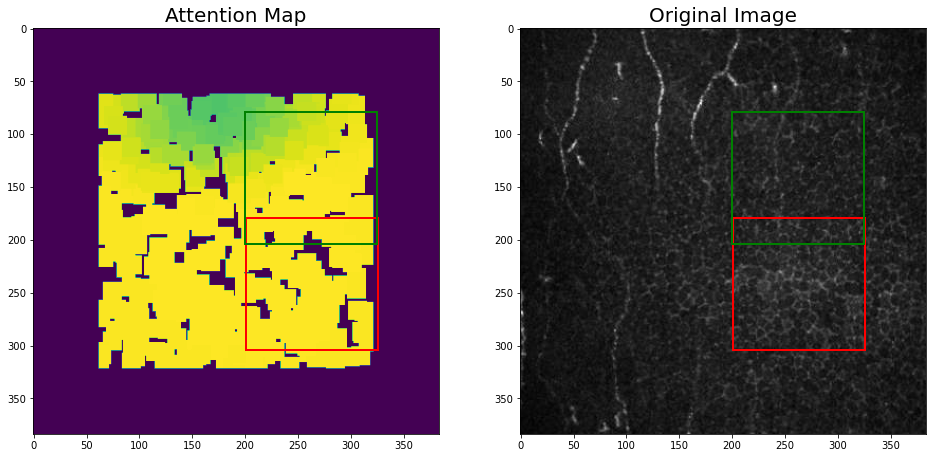

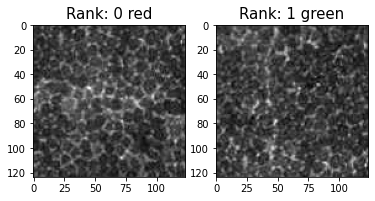

In [108]:
importlib.reload(ld)

tilesegmenter = st.TileSegmenter(
    n_tiles=2,
    tile_size=125,
    min_tile_dist=100,
    glcm_n_samples=500,
    canny_sigma=3,
    plot_patches=True,
    edge_weight=-2,
    contrast_weight=5,
    energy_weight=0.5,
    show_tqdm=True
)


i=3
metadata = ld.load_bcd_metadata()
example_sub = metadata.iloc[i]
example_scan = example_sub['cc scan 1']
patient_sample = example_sub['study_number_id_eye']
img_class = example_sub['clinical']
pid, img_slice = ld.convert_id_to_folder_label(
    patient_sample,
    example_scan
)

img = ld.get_bcd_image(img_class, pid, img_slice)
print(img_class + ' ' + pid + ' ' + img_slice)

patches = tilesegmenter.segment_tiles(img)

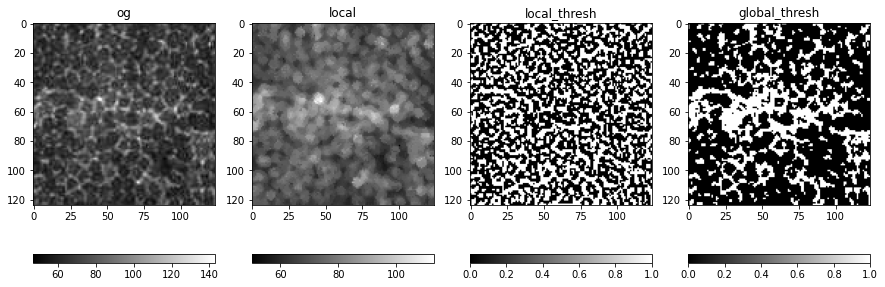

In [163]:
from skimage.morphology import disk
from skimage.filters import threshold_otsu, rank, gaussian
from skimage.util import img_as_ubyte

img = img_as_ubyte(patches[0])
radius = 3
selem = disk(radius)

local_otsu = rank.otsu(img, selem)
threshold_global_otsu = threshold_otsu(img)
global_otsu = img >= threshold_global_otsu
threshold_local_otsu = img >= local_otsu

fig, axes = plt.subplots(figsize=(15, 6), nrows=1, ncols=4)
ims = [img, local_otsu, threshold_local_otsu, global_otsu]
titles = ['og', 'local', 'local_thresh', 'global_thresh']
for i, im in enumerate(ims):
    ax = axes.flatten()[i]
    fig.colorbar(ax.imshow(im, cmap='gray'), ax=ax, orientation='horizontal')
    ax.set_title(titles[i])


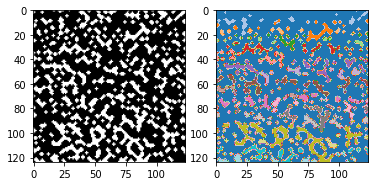

In [178]:
from skimage import morphology
from skimage import measure
from skimage import segmentation

eroded = morphology.binary_opening(threshold_local_otsu)
dilated = morphology.binary_closing(eroded)

labeled = measure.label(dilated, connectivity=1)
fig ,axes = plt.subplots(ncols=2, figsize=(6,6))
axes[0].imshow(dilated, cmap='gray')
axes[1].imshow(labeled, cmap='tab20')

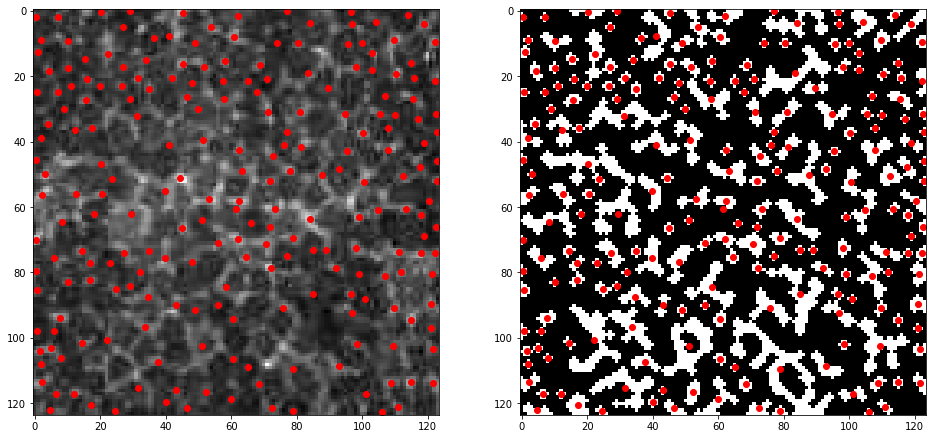

In [179]:
fig, axes = plt.subplots(ncols=2, figsize=(16,8))
ax1, ax2 = axes.flatten()
ax1.imshow(img, cmap='gray')
ax2.imshow(dilated, cmap='gray')

for n in np.unique(labeled):
    centroid = np.argwhere(labeled == n).mean(axis=0)
    ax1.scatter(centroid[1], centroid[0], c='red')
    ax2.scatter(centroid[1], centroid[0], c='red')
    
    